In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import cnn
import dataloader

import matplotlib.pyplot as plt
import numpy as np

import os
from tqdm import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model = cnn.model(num_blocks=[1,1,1], num_channels=1,num_classes=10)
model = model.to(device)

In [6]:
CELoss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)
best_acc = 0

In [7]:
def train(epoch, model, trainloader):
    print(f'Train Epoch:{epoch}')
    model.train()
    
    batch_train_loss = []
    with tqdm(total=len(trainloader)) as pbar:
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = CELoss(outputs, targets)
            loss.backward()
            optimizer.step()
            
            batch_train_loss.append(loss.item())
            pbar.update(1)
            
    return np.mean(batch_train_loss), batch_train_loss


def test(epoch, model, testloader):
    global best_acc
    model.eval()
    batch_test_loss = []
    batch_correct = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = CELoss(outputs, targets)
            batch_test_loss.append(loss.item())
            
            _, predicted = torch.max(outputs, axis=1)
            batch_correct.append(predicted.eq(targets).numpy())
    
    batch_correct = np.array(batch_correct)
    correct = batch_correct.sum()
    total = batch_correct.size
    
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    
    return np.array(batch_test_loss).mean(), batch_test_loss, acc

In [8]:
dataiter = iter(dataloader.testloader)

In [9]:
data = dataiter.next()

In [10]:
model(data[0]).shape

torch.Size([100, 10])

In [16]:
train_loss_list = []
test_loss_list = []
acc_list = []
for epoch in range(20):
    _,train_loss = train(epoch, model, dataloader.trainloader)
    _,test_loss, acc = test(epoch, model, dataloader.testloader)
    scheduler.step()
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    acc_list.append(acc)

  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:1
  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:2
  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:3
  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:5
  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:6
  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:7
  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:10
  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:11
  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:12
  0%|          | 0/938 [00:00<?, ?it/s]Saving..
Train Epoch:18
100%|██████████| 938/938 [01:48<00:00,  8.66it/s]


In [17]:
import matplotlib.pyplot as plt

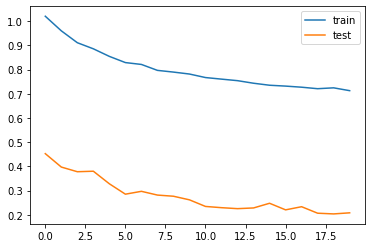

In [22]:
plt.figure()
plt.plot(np.array(train_loss_list).mean(axis=1), label='train')
plt.plot(np.array(test_loss_list).mean(axis=1), label='test')
plt.legend()

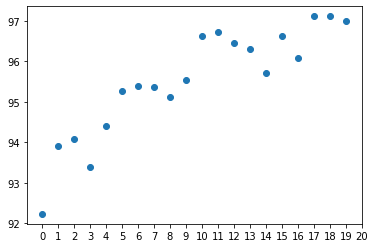

In [26]:
plt.plot(acc_list,'o')
plt.xticks(np.arange(0, 20 + 1, 1))
plt.show()